<a href="https://colab.research.google.com/github/nisharamanna555/ResponsibleDataScience/blob/main/lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 10 - MlInspect

### Overview of the example from the paper


![paper_example_image](https://github.com/stefan-grafberger/mlinspect/blob/master/demo/feature_overview/paper_example_image.png?raw=true)

Example of an ML pipeline that predicts which patients are at a higher risk of serious complications, under the requirement to achieve comparable false negative rates across intersectional groups by age and race. The pipeline is implemented using native constructs from the popular pandas and scikit-learn libraries. On the left, we highlight potential issues identified by mlinspect. On the right, we show the corresponding dataflow graph extracted by mlinspect to instrument the code and pinpoint issues.

## Task
Operators like joins, selections and missing value imputaters can cause data distribution issues, which can heavily impact the performance of our model for specific demographic groups. Mlinspect helps with identifying such issues by offering a check that calculates histograms for sensitive groups in the data and verifying whether the histogram change is significant enough to alert the user. Thanks to our annotation propagation, we can deal with complex code involving things like nested sklearn pipelines and group memberships that are removed from the training data using projections.

We want to find out if preprocessing operations in pipelines introduce bias and if so, which groups are effected. The pipeline we want to analyse in this task can be found using the path os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_modified.py"). The senstive attributes we want to take a look at are race and sex.

It is using a benchmark dataset frequently used in the algorithmic fairness literature. Adult income contains information about 33,000 individuals from the 1994 U.S. census, with sensitive attributes gender and race. The corresponding task is to predict whether the annual income of an individual exceeds $50,000. We took this existing data set and only modified it slightly by introducing an artificial issue which we will now try to find using mlinspect.

The code of the pipeline:

> ```python
> """
> Adult income pipeline
> """
> import os
> import pandas as pd
> from sklearn import compose, preprocessing, tree, pipeline
>
> from mlinspect.utils import get_project_root
>
> print('pipeline start')
>
> train_file_a = os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_train_a.csv")
> raw_data_a = pd.read_csv(train_file_a, na_values='?', index_col=0)
>
> train_file_b = os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_train_b.csv")
> raw_data_b = pd.read_csv(train_file_b, na_values='?', index_col=0)
>
> merged_raw_data = raw_data_a.merge(raw_data_b, on="id")
>
> data = merged_raw_data.dropna()
>
> labels = preprocessing.label_binarize(data['income-per-year'], classes=['>50K', '<=50K'])
>
> column_transformer = compose.ColumnTransformer(transformers=[
>     ('categorical', preprocessing.OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
>     ('numeric', preprocessing.StandardScaler(), ['age', 'hours-per-week'])
> ])
> adult_income_pipeline = pipeline.Pipeline([
>     ('features', column_transformer),
>     ('classifier', tree.DecisionTreeClassifier())])
>
> adult_income_pipeline.fit(data, labels)
> print('pipeline finished')
> ```

# Step 1/4: Add check and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file.

First, we define the check we want mlinspect to run. In this example, we only use `NoBiasIntroducedFor(["col1", "col2", ...])` to automatically check for significant changes in the distribution of sensitive demograhpic groups and compute the histograms.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which, among other information, contains the output of our check.

In [ ]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz
!SETUPTOOLS_USE_DISTUTILS=stdlib pip install git+https://github.com/stefan-grafberger/mlinspect.git@c2207ef058e5fb28cc74c72c7c9f3deed04fc639
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install jinja2==3.0.3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

In [2]:
import urllib
from inspect import cleandoc

import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor, NoIllegalFeatures
from mlinspect.inspections import MaterializeFirstOutputRows

In [3]:
python_string = cleandoc("""
import os
import pandas as pd
from sklearn import compose, preprocessing, tree, pipeline

from mlinspect.utils import get_project_root

print('pipeline start')
raw_data_a = pd.read_csv('https://raw.githubusercontent.com/DataResponsibly/Datasets/master/dataset_lab_6/adult_simple_train_a.csv')
raw_data_b = pd.read_csv('https://raw.githubusercontent.com/DataResponsibly/Datasets/master/dataset_lab_6/adult_simple_train_b.csv')

merged_raw_data = raw_data_a.merge(raw_data_b, on="id")

data = merged_raw_data.dropna()

labels = preprocessing.label_binarize(data['income-per-year'], classes=['>50K', '<=50K'])

column_transformer = compose.ColumnTransformer(transformers=[
    ('categorical', preprocessing.OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
    ('numeric', preprocessing.StandardScaler(), ['age', 'hours-per-week'])
])
adult_income_pipeline = pipeline.Pipeline([
    ('features', column_transformer),
    ('classifier', tree.DecisionTreeClassifier())])

adult_income_pipeline.fit(data, labels)
print('pipeline finished')
""")

In [4]:
inspector_result = PipelineInspector\
    .on_pipeline_from_string(python_string) \
    .add_check(NoBiasIntroducedFor(['race', 'sex'])) \
    .add_check(NoIllegalFeatures()) \
    .add_required_inspection(MaterializeFirstOutputRows(5)) \
    .execute()

extracted_dag = inspector_result.dag
check_results = inspector_result.check_to_check_results
inspection_results = inspector_result.dag_node_to_inspection_results

pipeline start


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


pipeline finished


# Step 2/4: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see our some check failed. We do this using the mlinspect utlity function `check_results_as_data_frame(...)`. We see that an issue was found, so we have to investigate it.

In [5]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('race', 'sex'), -0.3))",CheckStatus.FAILURE,"A Join causes a min_relative_ratio_change of 'sex' by -0.4009821195113874, a value below the configured minimum threshold -0.3!"
1,NoIllegalFeatures(),CheckStatus.FAILURE,Used illegal columns: ['age']


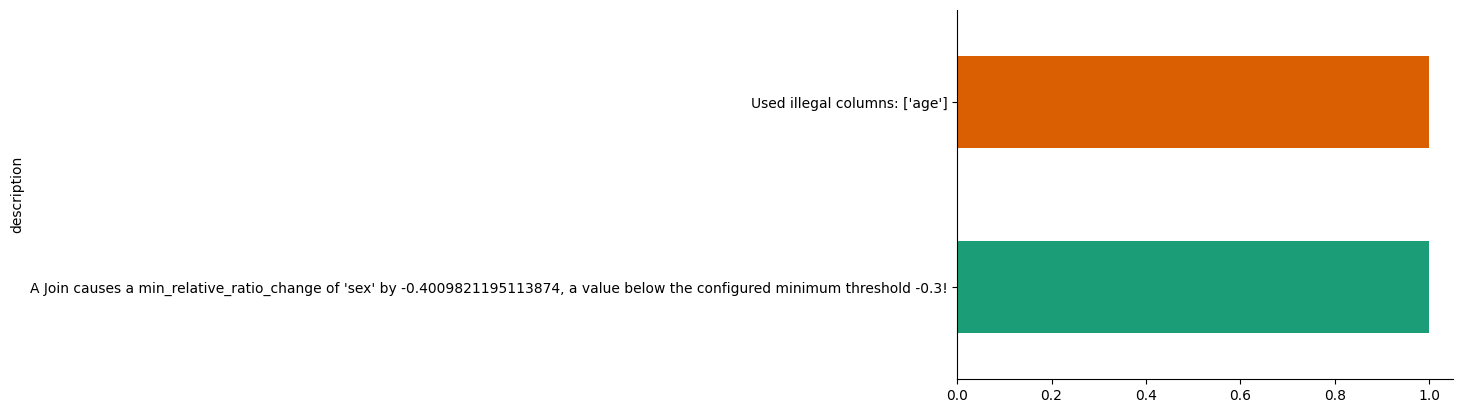

In [10]:
# @title description

from matplotlib import pyplot as plt
import seaborn as sns
check_result_df.groupby('description').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

A negative min_relative_ratio_change means that the ratio after the join is less than the original ratio

https://github.com/stefan-grafberger/mlinspect/blob/19ca0d6ae8672249891835190c9e2d9d3c14f28f/mlinspect/checks/_no_bias_introduced_for.py

# Step 3/4: List of operations that could change the distribution

As stated before, only some operations like selections, joins and missing value imputation can change the distribution. Our check already filtered all operators that can cause data distribution issues. We can use the mlinspect utility function `get_distribution_changes_overview_as_df(...)` to get an overview. The overview already tells us that mlinspect detected a potential issue caused by a JOIN involving the gender attribute. Note that the automatic issue detection from mlinspect is only as good as its configuration and should not be completely relied upon.

In [6]:
no_bias_check_result = check_results[NoBiasIntroducedFor(["race", "sex"])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,operator_type,description,code_reference,source_code,module,'race' distribution change below the configured minimum test threshold,'sex' distribution change below the configured minimum test threshold
0,OperatorType.JOIN,on 'id',"CodeReference(lineno=11, col_offset=18, end_lineno=11, end_col_offset=55)","raw_data_a.merge(raw_data_b, on=""id"")","FunctionInfo(module='pandas.core.frame', function_name='merge')",False,True
1,OperatorType.SELECTION,dropna,"CodeReference(lineno=13, col_offset=7, end_lineno=13, end_col_offset=31)",merged_raw_data.dropna(),"FunctionInfo(module='pandas.core.frame', function_name='dropna')",False,False


# Step 4/4 Detailed Investigation

### NoBiasIntroduced
Now that we know of the potential issue, we will take a look at the histograms before and after the JOIN. We can use `distribution_change.before_and_after_df` to look at the data in form of a `pandas.DataFrame` or use the mlinspect utility function `plot_distribution_change_histograms(...)` to plot the histograms.

OperatorType.JOIN

 Column 'race', acceptable change: True, min_relative_ratio_change: -0.10798782300224391


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Amer-Indian-Eskimo,218,180,0.009565,0.009460,-0.010927
1,Asian-Pac-Islander,737,623,0.032336,0.032743,0.012588
2,Black,2154,1604,0.094507,0.084301,-0.107988
3,Other,197,158,0.008643,0.008304,-0.039266
4,White,19486,16462,0.854949,0.865192,0.011980


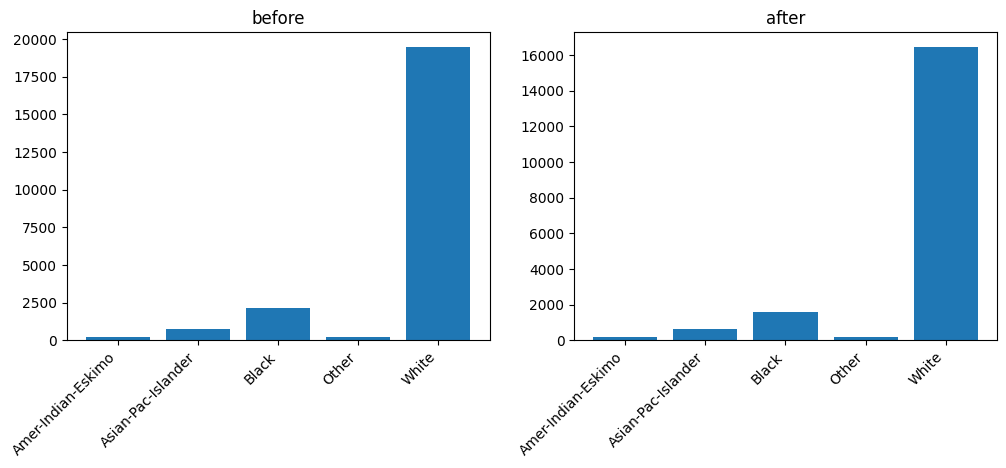


 Column 'sex', acceptable change: False, min_relative_ratio_change: -0.4009821195113874


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Female,7531,3766,0.330423,0.197929,-0.400982
1,Male,15261,15261,0.669577,0.802071,0.197877


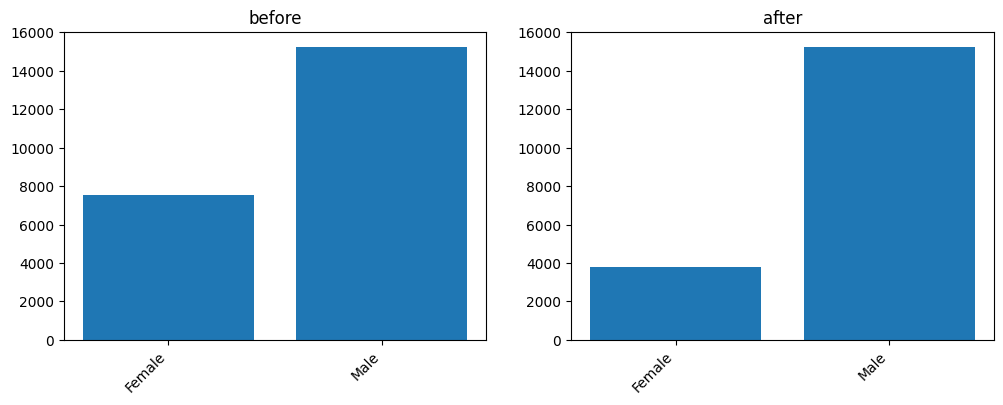

In [7]:
# Select the DagNode we want to look at by index
dag_node, node_distribution_changes = dag_node_distribution_changes_list[0]

# Investige the changes
print(dag_node.operator_info.operator)
for column, distribution_change in node_distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

### Use of illegal features:

https://github.com/stefan-grafberger/mlinspect/blob/19ca0d6ae8672249891835190c9e2d9d3c14f28f/mlinspect/checks/_no_illegal_features.py

In [8]:
feature_check_result = check_results[NoIllegalFeatures()]
print("Used illegal features: {}".format(feature_check_result.illegal_features))

Used illegal features: ['age']


### MaterializeFirstOutputRows
For each operator, the MaterializeFirstOutputRows materialized the first 5 output rows. Especially for scikit-learn pipelines, it requires custom debugging code if a user just wants to look at some intermediate results ([see example stackoverflow post](https://stackoverflow.com/questions/34802465/sklearn-is-there-any-way-to-debug-pipelines)). Using mlinspect, this becomes easy. We can look at the input and output of arbitrary featurizers like OneHotEncoders or Word2Vec models.

Here, we use this functionality to look at the output of a OneHotEncoder and the projection right before it. For this, we only need to look at the inspection result for the corresponding Dag nodes.

In [9]:
from IPython.display import display

relevant_nodes = {
    "One-Hot Encoder: fit_transform", "to ['education', 'workclass']" }

for dag_node, node_inspection_result in inspection_results.items():
  if dag_node.details.description in relevant_nodes:
    #print(dag_node.details.description)
    first_rows_inspection_result = node_inspection_result[MaterializeFirstOutputRows(5)]
    if first_rows_inspection_result is not None:

        print("\n\033[1m{} ({})\033[0m\n{}".format(
            dag_node.operator_info.operator, dag_node.details.description, dag_node.optional_code_info))
        display(first_rows_inspection_result)


OperatorType.PROJECTION (to ['education', 'workclass'])
OptionalCodeInfo(code_reference=CodeReference(lineno=17, col_offset=21, end_lineno=20, end_col_offset=2), source_code="compose.ColumnTransformer(transformers=[\n    ('categorical', preprocessing.OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),\n    ('numeric', preprocessing.StandardScaler(), ['age', 'hours-per-week'])\n])")


,education,workclass
0,Some-college,Local-gov
1,HS-grad,Private
2,HS-grad,Private
3,Assoc-acdm,Self-emp-not-inc
4,7th-8th,Private



OperatorType.TRANSFORMER (One-Hot Encoder: fit_transform)
OptionalCodeInfo(code_reference=CodeReference(lineno=18, col_offset=20, end_lineno=18, end_col_offset=72), source_code="preprocessing.OneHotEncoder(handle_unknown='ignore')")


,array
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


### Question: Did we find operators that introduce bias? How did the distribution of demographic groups change?
**Write down your answer here:** We found that the operator "JOIN" introduced bias. It skewed the distribution between men and women. Specifically, it drastically decreased the number of data points associated with the "Female" demographic.

#### Question: Can missing value imputation cause bias? If so, how?
**Write down your answer here:** Missing value imputation can cause bias. Decreasing the number of data points associated with certain demographics can decrease the model's accuracies for these demographics, which causes bias against these demographics.